<h3>Requirements

---

In [1]:
pip install transformers torch datasets scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

<h3>Dataset Loading

---



In [4]:
data = pd.read_csv('/content/drive/MyDrive/Project/train.csv')

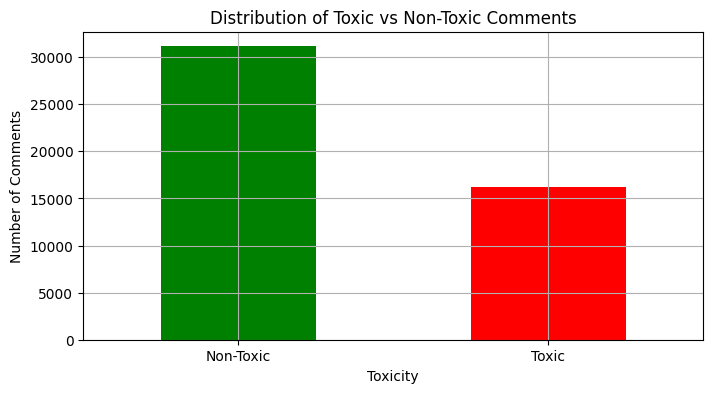

Toxic comments:  16225
Non-toxic comments:  31144
Percentage of Toxic Comments: 34.25%
Percentage of Non-Toxic Comments: 65.75%


In [5]:
# Number of toxic and non-toxic comments

column_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data['is_toxic'] = data[column_labels].any(axis=1)
toxic_counts = data['is_toxic'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 4))
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.xlabel('Toxicity')
plt.ylabel('Number of Comments')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'], rotation=0)
plt.grid(True)
plt.show()

# Display count
print("Toxic comments: ", toxic_counts[True])
print("Non-toxic comments: ", toxic_counts[False])

# Given numbers
x = toxic_counts[True]
y = toxic_counts[False]
total_comments = x + y

# Calculate percentage of toxic and non-toxic comments
percentage_toxic = (x / total_comments) * 100
percentage_non_toxic = (y / total_comments) * 100

# Print results
print(f"Percentage of Toxic Comments: {percentage_toxic:.2f}%")
print(f"Percentage of Non-Toxic Comments: {percentage_non_toxic:.2f}%")

<ipython-input-6-be37bd575745>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.values,


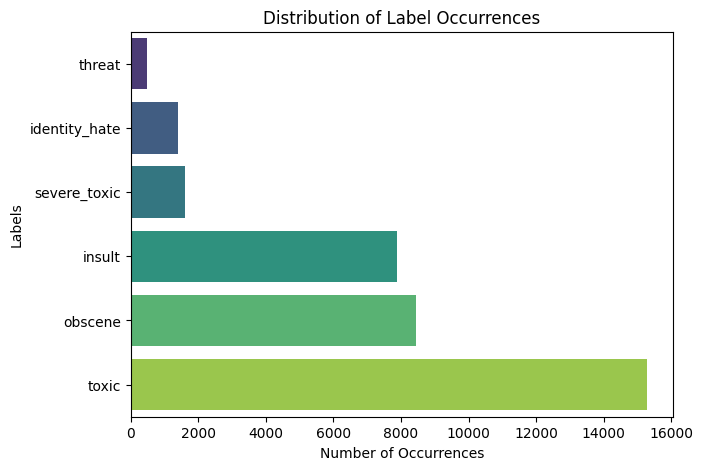

In [6]:
# Visualizing the class distribution of the 'label' column
column_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = data[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()

<h3>Tokenization

---



In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['comment_text'], padding='max_length', truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
data = Dataset.from_pandas(data)
data = data.map(tokenize_function, batched=True)
data = data.rename_column('comment_text', 'text')

Map:   0%|          | 0/47369 [00:00<?, ? examples/s]

In [9]:
# Train - Test split
train_dataset, test_dataset = data.train_test_split(test_size=0.2).values()

In [10]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

<h3>Model Loading

---



In [11]:
# Load BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
)

# Custom Trainer class to handle multi-label classification
class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

# Prepare labels for training
def prepare_labels(batch):
    labels = torch.stack([batch['toxic'], batch['severe_toxic'], batch['obscene'], batch['threat'], batch['insult'], batch['identity_hate']], dim=1).float()
    batch["labels"] = labels
    return batch

train_dataset = train_dataset.map(prepare_labels, batched=True)
test_dataset = test_dataset.map(prepare_labels, batched=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/37895 [00:00<?, ? examples/s]

Map:   0%|          | 0/9474 [00:00<?, ? examples/s]

In [13]:
# Trainer
trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

<h3>Training

---



In [14]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.100900,0.103844


TrainOutput(global_step=4737, training_loss=0.12344961506620299, metrics={'train_runtime': 3966.1099, 'train_samples_per_second': 9.555, 'train_steps_per_second': 1.194, 'total_flos': 9970951530608640.0, 'train_loss': 0.12344961506620299, 'epoch': 1.0})

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
predictions = trainer.predict(test_dataset)
predicted_labels = torch.sigmoid(torch.tensor(predictions.predictions)).round().numpy()
true_labels = test_dataset["labels"]

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='micro')
recall = recall_score(true_labels, predicted_labels, average='micro')
f1 = f1_score(true_labels, predicted_labels, average='micro')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.7939
Precision: 0.8283
Recall: 0.8256
F1-score: 0.8269


In [17]:
#Saving Model
trainer.save_model('/content/drive/MyDrive/Project/saved_model_bert')

In [18]:
#Loading Model
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Project/saved_model_bert')

<h3>Testing Model

---



In [19]:
# Testing
def classify_comment(comment):
    inputs = tokenizer(comment, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    return predictions

new_comment = "i will kill you."
predictions = classify_comment(new_comment)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
predicted_labels = {label: prediction for label, prediction in zip(labels, predictions[0])}
print(f"Comment: '{new_comment}' has predictions: {predicted_labels}")

Comment: 'i will kill you.' has predictions: {'toxic': array([ 4.5604224, -2.8728514,  2.1079628, -4.8647494,  1.9324969,
       -4.179103 ], dtype=float32), 'severe_toxic': array([-5.4212136, -6.6943088, -6.3095746, -6.570983 , -6.0260744,
       -6.539112 ], dtype=float32), 'obscene': array([ 0.3027378 , -4.619932  ,  0.31555358, -6.048946  , -2.5150368 ,
       -5.0598054 ], dtype=float32), 'threat': array([-1.4868343, -6.2617006, -5.291627 , -5.569059 , -3.7762656,
       -3.1871052], dtype=float32), 'insult': array([-5.045144 , -6.691555 , -6.3572593, -6.584201 , -5.6933117,
       -6.48109  ], dtype=float32), 'identity_hate': array([ 2.2702713, -5.4827127, -2.887251 , -5.0167246, -0.6336382,
       -3.5163105], dtype=float32)}


<h3>Interface

---



In [20]:
!pip install gradio
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.

In [21]:
def classify_comment(comment):
  inputs = tokenizer(comment, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
  inputs = {k: v.to(model.device) for k, v in inputs.items()}
  outputs = model(**inputs)
  predictions = torch.sigmoid(outputs.logits).cpu().detach().numpy()
  labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
  predicted_labels = {label: prediction for label, prediction in zip(labels, predictions[0])}
  return predicted_labels

demo = gr.Interface(
    fn=classify_comment,
    inputs=gr.Textbox(lines=5, label="Enter a Comment"),
    outputs=gr.Label(label="Comment Toxicity Analyzer"),
)

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2cd0d9ab65016ebb90.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
